/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: covariance is not positive-semidefinite.


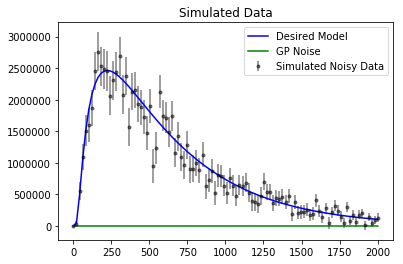

In [16]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import celerite as ce
from celerite.modeling import Model
import QPP_Funcs as QPP
from scipy.optimize import minimize, curve_fit

#setting our desired parameters that we want to "find"
paramstrue = [1e3, 1e-2, 3.2e+06, 1e+02, 5e+02]
log_paramstrue = np.log(paramstrue)

#defining a model class in celerite with our continuous model
class CTSModel_prior(Model):
    parameter_names = ("log_A", "log_tau1", "log_tau2")
    
    def get_value(self, t):
        lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
        return np.exp(self.log_A)*lam*np.exp((-np.exp(self.log_tau1)/t)-(t/np.exp(self.log_tau2)))
    
    #the gradient terms were manually calculated
    def compute_gradient(self, t):
        lam = np.exp(np.sqrt(2*np.exp(self.log_tau1-self.log_tau2)))
        dA = (1./np.exp(self.log_A)) * self.get_value(t)
        dtau1 = ((1/(np.exp(self.log_tau2) * np.log(lam))) - (1/t)) * self.get_value(t)
        dtau2 = ((t/(np.exp(self.log_tau2)**2)) - (np.exp(self.log_tau1)/((np.exp(self.log_tau2)**2) * np.log(lam)))) * self.get_value(t)
        return np.array([dA, dtau1, dtau2])
        
    #defining our somewhat naive prior, a simple tophat distribution for each parameter
    def log_prior(self):
        probA = 1.
        probtau1 = 1.
        probtau2 = 1.
        T=2000.
        if not (self.log_A>np.log(1e4) and self.log_A<np.log(3.5e7)):
            probA = 0.
        if not ((self.log_tau1>np.log(1) and self.log_tau1<np.log(T))):
            probtau1 = 0.
        if not ((self.log_tau2>self.log_tau1 and self.log_tau2<np.log(T))):
            probtau2 = 0.
        return np.log(probA * probtau1 * probtau2 * np.e)

truemodel = CTSModel_prior(log_A = log_paramstrue[2], log_tau1 = log_paramstrue[3], log_tau2 = log_paramstrue[4])    

#defining the kernel from the celerite RealTerm class so I can set my own prior
class RealTerm_Prior(ce.terms.RealTerm):

    def log_prior(self):
        prob_a = 1.
        prob_c = 1.
        
        #again, using simple (naive) tophat distributions
        if not ((self.log_a > -1e5) and (self.log_a < np.log(1e6))):
            prob_a = 0.
        if not (self.log_c > np.log(1./1000) and self.log_c < np.log(100)):
            prob_c = 0.
        return np.log(prob_a*prob_c * np.e)


#defining my simulation method using the kernel
def simulate(x, yerr, model, kernel):
    #generates a covariance matrix and then data using the multivariate normal distribution
    #could this be where the error is????
    K = kernel.get_value(x[:, None] - x[None, :])
    K[np.diag_indices(len(x))] += yerr**2
    y = np.random.multivariate_normal(model.get_value(x), K)
    return np.abs(y)

truekernel =  RealTerm_Prior(log_a = log_paramstrue[0], log_c = log_paramstrue[1])


#generating our simulated data
N = 100
x = np.linspace(1,2001,N)
ytrue = simulate(x, np.zeros(len(x)), truemodel, truekernel)
yerrscale = 2e2
yerr = np.sqrt(ytrue) * yerrscale
plt.figure()
plt.plot(x, ytrue, 'b-', label = "Desired Model")

ysim = simulate(x, yerr, truemodel, truekernel)

plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.plot(x, ytrue-truemodel.get_value(x), 'g-', label = "GP Noise")

plt.title("Simulated Data")
plt.legend()

plt.show()


In [17]:
#guessing initial model parameters
guess = np.array([np.log(2.5e6), np.log(50), np.log(100)])
model = CTSModel_prior(log_A = guess[0], log_tau1 = guess[1], log_tau2 = guess[2])

Initial log-likelihood: -2270.34823466
True log-likelihood: -1327.43931538
Final log-likelihood: -1335.85582176
Optimized log-parameters: [  5.83950341   2.30258509  14.81164874   4.37213918   6.36567336]
True log-parameters: [  6.90775528  -4.60517019  14.97866137   4.60517019   6.2146081 ]


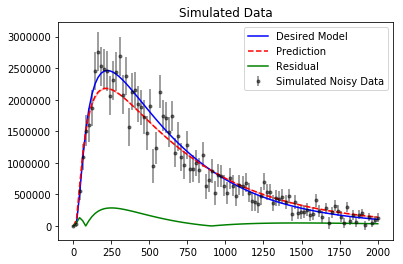

In [18]:
#initializing kernal and GP
kernel = RealTerm_Prior(log_a = np.log(500), log_c = np.log(10))

gp = ce.GP(kernel, mean = model, fit_mean = True)
gp.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(ysim)))

#defining fitting functions for our GP
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

#setting initial terms and then optimizing
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

gp.set_parameter_vector(log_paramstrue)
print("True log-likelihood: {0}".format(gp.log_likelihood(ysim)))

gp.set_parameter_vector(initial_params)
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(ysim, gp))

gp.set_parameter_vector(soln.x)
print("Final log-likelihood: {0}".format(-soln.fun))
print ("Optimized log-parameters: " + str(soln.x))
print ("True log-parameters: " + str(log_paramstrue))
ytest, yvar = gp.predict(ysim, x, return_var=True)
ystd = np.sqrt(yvar)


#plotting our predictions as well as our original data and fit model
plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r--', label = "Prediction")
plt.fill_between(x, ytest+ystd, ytest-ystd, color='r', alpha=0.3, edgecolor='none')
plt.plot(x, np.abs(ytrue-ytest), 'g-', label = "Residual")
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()


plt.show()


In [19]:
paramstart = soln.x
gp.set_parameter_vector(paramstart)
gp.compute(x, yerr)
#probability function for MCMC
def log_probability(params, y, gp):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    ll = gp.log_likelihood(y)
    result = ll + lp
    
    if not (np.isfinite(lp)):
        return -np.inf
    if np.isnan(ll)==True:
        return -np.inf
    return result


#sampling function for mcmc
def samplepdf(params):
    return np.random.normal(loc=params, scale = np.sqrt(np.abs(params)/7500.))



In [20]:
#initializing and running emcee sampler using same startpoint as MH-MCMC

import emcee
import corner

ndim = 5
nwalkers = 100
nsteps = 500
start = [samplepdf(paramstart) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ysim, gp))
sampler.run_mcmc(start, nsteps)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log


(array([[ -2.65628825e+04,  -6.66953887e+00,   1.49620948e+01,
           4.56424998e+00,   6.22446661e+00],
        [ -8.89342091e+03,  -2.79522194e+00,   1.49104287e+01,
           4.55912096e+00,   6.23566823e+00],
        [ -3.26878175e+04,  -1.52391493e+00,   1.48809955e+01,
           4.42461207e+00,   6.28504763e+00],
        [ -7.99368221e+04,   3.25989181e+00,   1.49095107e+01,
           4.42953053e+00,   6.25750833e+00],
        [ -9.33696997e+02,   5.02329535e-01,   1.48351909e+01,
           4.38002265e+00,   6.29861854e+00],
        [ -4.05061685e+04,   1.79882237e+00,   1.49221194e+01,
           4.58581219e+00,   6.25380806e+00],
        [ -2.85614120e+04,  -2.31768597e+00,   1.49533571e+01,
           4.54697507e+00,   6.21028712e+00],
        [ -3.81003738e+03,   7.37652060e-01,   1.49562570e+01,
           4.48930514e+00,   6.23488571e+00],
        [ -2.30545708e+04,   4.53852573e+00,   1.49448343e+01,
           4.46125912e+00,   6.21758670e+00],
        [ -2.521756

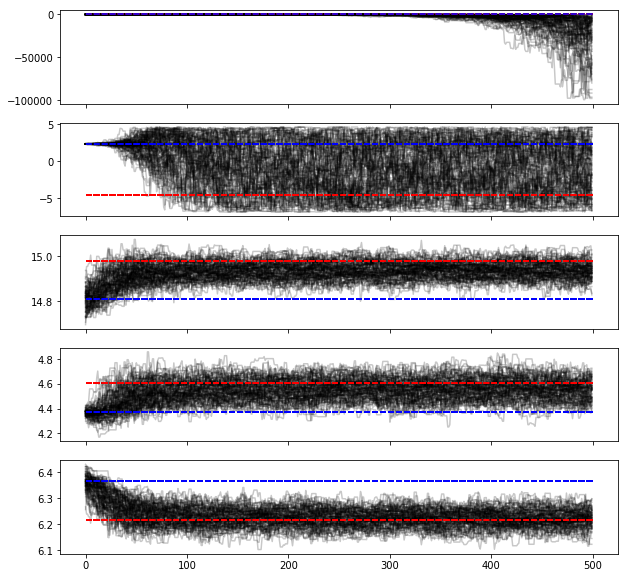

In [21]:
fig, axarr = plt.subplots(5, sharex=True, figsize = (10,10))
xline = np.linspace(0,nsteps)

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot(np.arange(nsteps), sampler.chain[i,:,j], 'k-', alpha=1./np.log(nwalkers))
        trueval = log_paramstrue[j] * np.ones(len(xline))
        optval = soln.x[j] * np.ones(len(xline))
        axarr[j].plot(xline, trueval, 'r--')
        axarr[j].plot(xline, optval, 'b--')
plt.show()

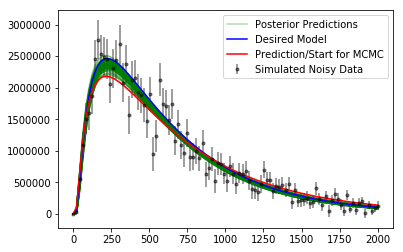

In [22]:
#plotting a sampling of results from emcee MCMC along with my previous work

labeled = False
for i in range(nsteps/10):
    params = sampler.chain[np.random.randint(nwalkers),np.random.randint(100,nsteps)]
    gp.set_parameter_vector(params)
    
    ymc, ymcvar = gp.predict(ysim, x, return_var=True)
    ymcstd = np.sqrt(ymcvar)
    if not np.isnan(ymc).any():
        if labeled == False:
            plt.plot(x, ymc, 'g-', alpha = 0.3, label = "Posterior Predictions")
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.3, edgecolor='none')
            labeled = True
        else:  
            plt.plot(x, ymc, 'g-', alpha = 0.3)
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.3, edgecolor='none')

plt.plot(x, ytrue, 'b-', label = "Desired Model")
plt.plot(x, ytest, 'r-', label = "Prediction/Start for MCMC")
plt.fill_between(x, ytest+ystd, ytest-ystd, color='r', alpha=0.3, edgecolor='none')
plt.errorbar(x, ysim, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

            
plt.legend()    
plt.show()

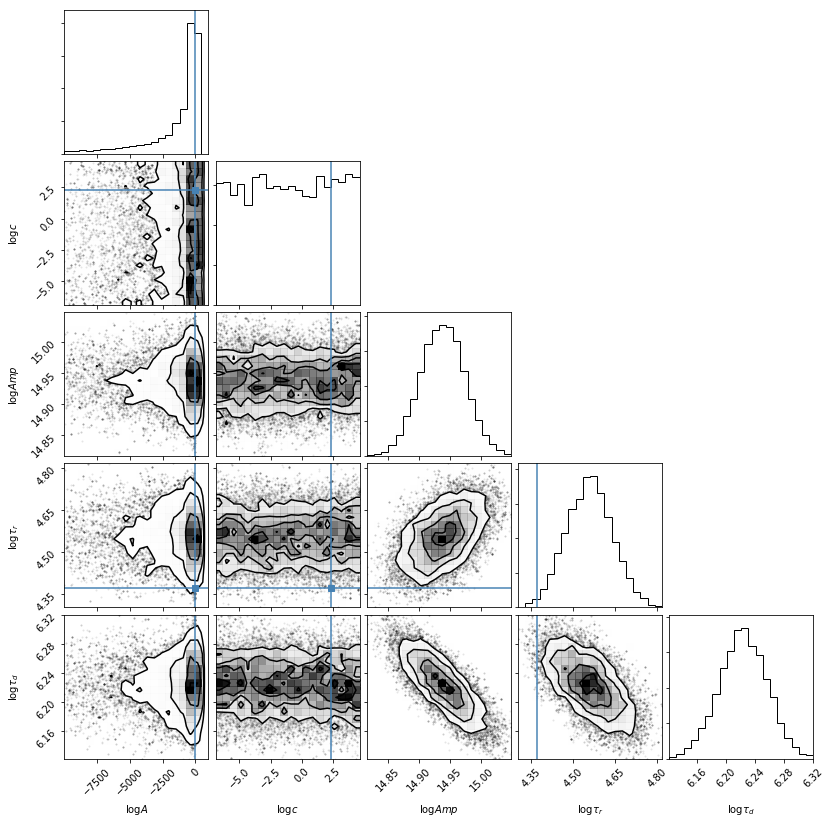

In [23]:
flat_samples = sampler.chain[:,200:, :].reshape((-1,ndim))
fig = corner.corner(flat_samples, labels = [r"$\log{A}$", r"$\log{c}$", r"$\log{Amp}$", r"$\log{\tau_r}$", r"$\log{\tau_d}$"], truths = soln.x, range=[(-1e4,1e3),.99999,.999,.999,.999])
plt.show()

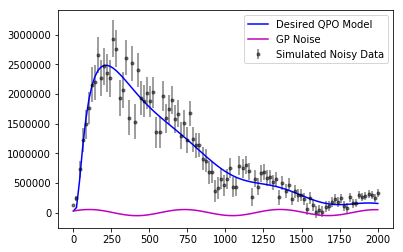

In [33]:
paramsq = [5e7, 1e4, 0.01, 3.2e+06, 1e+02, 5e+02]
log_paramsq = np.log(paramsq)

class SHOTerm_Prior(ce.terms.SHOTerm):
    def log_prior(self):
        prob_S0 = 1.
        prob_Q = 1.
        prob_omega0 = 1.
        
        #again, using simple (naive) tophat distributions
        if not ((self.log_S0 > -10) and (self.log_S0 < 20)):
            prob_S0 = 0.
        if not (self.log_Q > -10 and self.log_Q < 20):
            prob_Q = 0.
        if not (self.log_omega0 > -10 and self.log_omega0 < 20):
            prob_omega0 = 0.
        return np.log(prob_S0*prob_Q*prob_omega0 * np.e)
    
truemodelq = CTSModel_prior(log_A = log_paramsq[3], log_tau1 = log_paramsq[4], log_tau2 = log_paramsq[5])        
truekernelq = SHOTerm_Prior(log_S0 = log_paramsq[0], log_Q = log_paramsq[1], log_omega0 = log_paramsq[2])

plt.figure()
ytrueq = simulate(x, np.zeros(len(x)), truemodelq, truekernelq)
plt.plot(x, ytrueq, 'b-', label = "Desired QPO Model")
ysimq = simulate(x, yerr, truemodelq, truekernelq)
plt.errorbar(x, ysimq, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")
gpnoiseq = ytrueq-truemodelq.get_value(x)
plt.plot(x, gpnoiseq, 'm-', label = "GP Noise")
plt.legend()
plt.show()



Initial log-likelihood: -12734.0742832
True log-likelihood: -1335.7287557
Final log-likelihood: -1370.13043658
Optimized log-parameters: [  7.30729325   7.28731216   8.60994128  14.80873145   4.29824017
   6.38590922]
True log-parameters: [ 17.72753356   9.21034037  -4.60517019  14.97866137   4.60517019
   6.2146081 ]


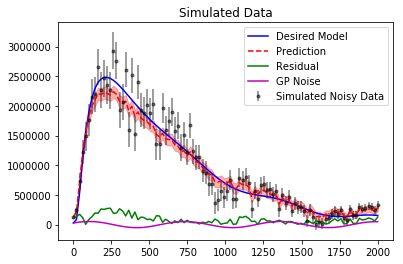

In [34]:
#initializing kernal and GP
kernelq = SHOTerm_Prior(log_S0 = np.log(50), log_Q = np.log(50), log_omega0 = np.log(10))
guess = np.array([np.log(2.7e6), np.log(10), np.log(100)])
model = CTSModel_prior(log_A = guess[0], log_tau1 = guess[1], log_tau2 = guess[2])


gpq = ce.GP(kernelq, mean = model, fit_mean = True)
gpq.compute(x, yerr)
print("Initial log-likelihood: {0}".format(gpq.log_likelihood(ysimq)))


#setting initial terms and then optimizing
initial_params = gpq.get_parameter_vector()
bounds = gpq.get_parameter_bounds()

gpq.set_parameter_vector(log_paramsq)
print("True log-likelihood: {0}".format(gpq.log_likelihood(ysimq)))

gpq.set_parameter_vector(initial_params)
solnq = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds, args=(ysimq, gpq))

gpq.set_parameter_vector(solnq.x)
print("Final log-likelihood: {0}".format(-solnq.fun))
print ("Optimized log-parameters: " + str(solnq.x))
print ("True log-parameters: " + str(log_paramsq))
ytestq, yvarq = gpq.predict(ysimq, x, return_var=True)
ystdq = np.sqrt(yvarq)


#plotting our predictions as well as our original data and fit model
plt.plot(x, ytrueq, 'b-', label = "Desired Model")
plt.plot(x, ytestq, 'r--', label = "Prediction")
plt.fill_between(x, ytestq+ystdq, ytestq-ystdq, color='r', alpha=0.3, edgecolor='none')
plt.plot(x, np.abs(ytrueq-ytestq), 'g-', label = "Residual")
plt.plot(x, gpnoiseq, 'm-', label = "GP Noise")
plt.errorbar(x, ysimq, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")

plt.title("Simulated Data")
plt.legend()


plt.show()


In [35]:
paramstartq = solnq.x
gpq.set_parameter_vector(paramstartq)
gpq.compute(x, yerr)

ndim = 6
nwalkers = 100
nsteps = 500
start = [samplepdf(paramstartq) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ysimq, gpq))
sampler.run_mcmc(start, nsteps)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


(array([[  7.4426954 ,  10.82505811,   5.86823474,  14.97547922,
           4.53340981,   6.19477862],
        [  6.19994754,  11.42833889,   4.86764632,  14.97950991,
           4.52354563,   6.23669214],
        [  3.75481433,  13.04055028,   6.93527829,  14.9231027 ,
           4.41479462,   6.29660436],
        [  0.21729149,  12.58836474,   9.98925865,  14.95302935,
           4.48341356,   6.25890768],
        [  9.28653976,   8.91624721,   4.90518436,  15.05272113,
           4.4718723 ,   6.15659587],
        [  7.29251183,   9.90974904,   6.09890066,  14.93105594,
           4.30859757,   6.3029127 ],
        [ 12.12792919,   8.31607478,   2.87454753,  15.03208452,
           4.46705626,   6.23935717],
        [  3.6697366 ,  13.25816573,   6.69767706,  14.97344803,
           4.68250926,   6.26653   ],
        [  7.05756108,  17.98212502,  -1.1976327 ,  15.02112443,
           4.53105254,   6.24045307],
        [ 16.02524746,  -5.12551822,  12.27941942,  14.94869874,
        

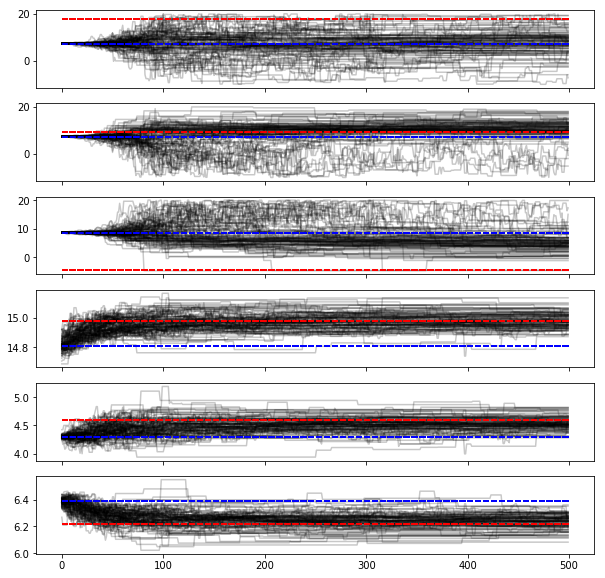

In [36]:
fig, axarr = plt.subplots(ndim, sharex=True, figsize = (10,10))
xline = np.linspace(0,nsteps)

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot(np.arange(nsteps), sampler.chain[i,:,j], 'k-', alpha=1./np.log(nwalkers))
        trueval = log_paramsq[j] * np.ones(len(xline))
        optval = solnq.x[j] * np.ones(len(xline))
        axarr[j].plot(xline, trueval, 'r--')
        axarr[j].plot(xline, optval, 'b--')
plt.show()

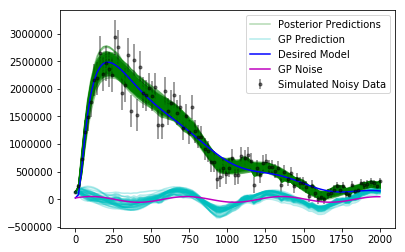

In [37]:
labeled = False
for i in range(nsteps/10):
    params = sampler.chain[np.random.randint(nwalkers),np.random.randint(100,nsteps)]
    gpq.set_parameter_vector(params)
    model.set_parameter_vector(params[3:])
    ymc, ymcvar = gpq.predict(ysimq, x, return_var=True)
    ymcstd = np.sqrt(ymcvar)
    gpnoisemc = ymc - model.get_value(x)
    if not np.isnan(ymc).any():
        if labeled == False:
            plt.plot(x, ymc, 'g-', alpha = 0.3, label = "Posterior Predictions")
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.3, edgecolor='none')
            plt.plot(x, gpnoisemc, 'c-', label = "GP Prediction", alpha=0.3)
            labeled = True
        else: 
            plt.plot(x, ymc, 'g-', alpha = 0.3)
            plt.fill_between(x, ymc+ymcstd, ymc-ymcstd, color='g', alpha=0.3, edgecolor='none')
            plt.plot(x, gpnoisemc, 'c-', alpha = 0.3)

plt.plot(x, ytrueq, 'b-', label = "Desired Model")
#plt.plot(x, ytestq, 'r-', label = "Prediction/Start for MCMC")
#plt.fill_between(x, ytestq+ystdq, ytestq-ystdq, color='r', alpha=0.3, edgecolor='none')
plt.plot(x, gpnoiseq, 'm-', label = "GP Noise")
plt.errorbar(x, ysimq, yerr=yerr, fmt='k.', alpha = 0.5, label = "Simulated Noisy Data")


            
plt.legend()    
plt.show()

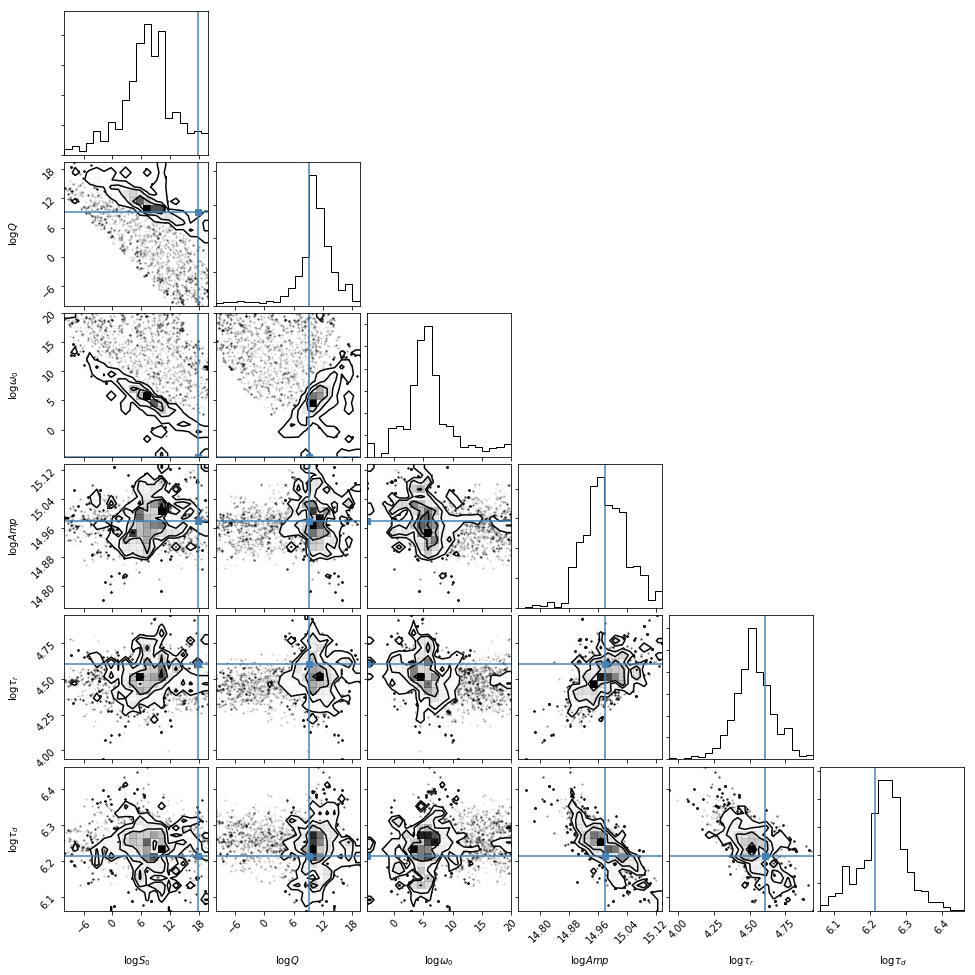

In [38]:
flat_samples = sampler.chain[:,200:, :].reshape((-1,ndim))
fig = corner.corner(flat_samples, labels = [r"$\log{S_0}$", r"$\log{Q}$", r"$\log{\omega_0}$", r"$\log{Amp}$", r"$\log{\tau_r}$", r"$\log{\tau_d}$"], truths = log_paramsq, range = [1,1,1,1,1,1])
plt.show()